# 使用 Spark 和 AWS Glue 交互式可视化完整的亚马逊客户评论数据集

在本notebook中，我们将使用 AWS Glue 与 PySpark 的交互式会话查询完整的评论数据。通过 [AWS Glue](https://aws.amazon.com/glue/) 交互式会话，可以快速构建、测试和运行数据准备和分析应用程序。交互式会话提供了一个编程接口，用于构建和测试用于数据准备的提取、转换和加载 (ETL) 脚本。对于需要分布式计算的大型数据集进行交互式开发的数据工程师和科学家来说，这是一个强大的工具，因为他们不需要管理 Spark 集群的基础架构。

在数据科学生命周期中，探索性数据分析 (EDA) 是数据科学家和工程师直观了解其数据集的重要一步。然后，这种直观的理解可以指导机器学习生命周期中更进一步的决策，例如模型训练、部署和监控。在本notebook中，我们将使用 PySpark 和 Spark SQL 对亚马逊评论数据集进行 EDA 和相关的可视化。

![glue-interactive-sessions](./img/gis.png)

<a name='1'></a>
## Set up Kernel and Required Dependencies

First, check that the correct kernel is chosen.

<img src="img/gis_kernel_set_up.png" width="300"/>

You can click on that to see and check the details of the image, kernel, and instance type.

<img src="img/gis_kernel_and_instance_type.png" width="600"/>

# 数据列描述

- `marketplace`: 2 个字母的国家/地区代码（在本例中全部为 “US”)
- `customer_id`: 随机标识符，可用于汇总单个作者撰写的评论
- `review_id`: 评论的唯一 ID
- `product_id`: 亚马逊标准识别码 (ASIN)  `http://www.amazon.com/dp/<ASIN>` 指向商品详情页面的链接
- `product_parent`: 该 ASIN 的父商品。多个 ASIN（同一商品的颜色或格式变体）可以合并为一个父商品
- `product_title`: 商品的标题描述
- `product_category`: 可用于对评论进行分组的广泛产品类别（在本例中为数字视频）
- `star_rating`: 该评论的评分（1 到 5 星）
- `helpful_votes`: 评论的有用票数
- `total_votes`: 评论获得的总票数
- `vine`: 这篇评论是作为 [Vine](https://www.amazon.com/gp/vine/help) 计划的一部分写的吗？
- `verified_purchase`: 评论来自经过验证的购买吗？
- `review_headline`: 评论的标题
- `review_body`: 评论的文本
- `review_date`: 撰写评论的日期
- `year`: 从审核日期得出的年份

In [3]:
%stop_session

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 0.38.4 
There is no current session.


In [6]:
# `%additional_python_modules seaborn,psutil`用于添加额外的Python模块。这里添加了seaborn和psutil两个模块。
%additional_python_modules seaborn,psutil
# `%number_of_workers 10`用于设置Notebook的工作进程数,这里将其设置为10个。
%number_of_workers 10

Additional python modules to be included:
seaborn
psutil
Previous number of workers: 5
Setting new number of workers to: 10


In [1]:
spark

Trying to create a Glue session for the kernel.
Worker Type: G.1X
Number of Workers: 10
Session ID: b175a9d3-6bd2-4a79-96b8-6255b755352b
Job Type: glueetl
Applying the following default arguments:
--glue_kernel_version 0.38.4
--enable-glue-datacatalog true
--additional-python-modules seaborn,psutil
Waiting for session b175a9d3-6bd2-4a79-96b8-6255b755352b to get into ready status...
Session b175a9d3-6bd2-4a79-96b8-6255b755352b has been created.


# Set Seaborn Parameters

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# 设置matplotlib的样式为seaborn-whitegrid
sns.set_style = "seaborn-whitegrid" 

sns.set(
    rc={
        "font.style": "normal", # 字体风格为正常
        "axes.facecolor": "white", # 坐标轴背景色为白色 
        "grid.color": ".8", # 网格颜色为灰色
        "grid.linestyle": "-", # 网格线型为实线
        "figure.facecolor": "white", # 图形背景色为白色
        "figure.titlesize": 20, # 图形标题字体大小为20
        "text.color": "black", # 文本颜色为黑色  
        "xtick.color": "black", # x轴刻度文字颜色为黑色
        "ytick.color": "black", # y轴刻度文字颜色为黑色
        "axes.labelcolor": "black", # 坐标轴标签颜色为黑色
        "axes.grid": True, # 显示坐标轴网格
        "axes.labelsize": 10, # 坐标轴标签字体大小为10
        "xtick.labelsize": 10, # x轴刻度标签字体大小为10
        "font.size": 10, # 文本字体大小为10
        "ytick.labelsize": 10, # y轴刻度标签字体大小为10
    }
)

"""
这段代码导入了numpy, pandas, seaborn和matplotlib模块,并配置了seaborn的默认样式和matplotlib的绘图参数。

主要作用:

1. 导入需要的模块
2. 设置seaborn默认样式为白色网格背景
3. 配置matplotlib各个元素的样式,包括字体、颜色、大小等参数

这样可以让后续的可视化都应用这些样式配置,从而保持绘图样式的一致性。
"""

'\n这段代码导入了numpy, pandas, seaborn和matplotlib模块,并配置了seaborn的默认样式和matplotlib的绘图参数。\n\n主要作用:\n\n1. 导入需要的模块\n2. 设置seaborn默认样式为白色网格背景\n3. 配置matplotlib各个元素的样式,包括字体、颜色、大小等参数\n\n这样可以让后续的可视化都应用这些样式配置,从而保持绘图样式的一致性。\n'


# 用于在条形图上显示值的辅助代码

In [3]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        # 对axes中的每个条形
        for p in ax.patches:
            # 获取条形的x,y坐标及宽高
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            # 获取条形的宽度并保留两位小数
            value = round(float(p.get_width()), 2)
            # 在条形右侧指定位置显示数值
            ax.text(_x, _y, value, ha="left")

    # 如果axs是数组,对每个axes执行操作
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    # 如果axs是单个axes,直接执行操作
    else:
        _show_on_plot(axs)

# 设置要查询的 Glue 数据库和表名

In [4]:
database_name = "default"
table_name = "amazon_reviews_parquet"

# 1. 哪些产品类别的平均评分最高？
## _这个查询需要一两分钟。请耐心等待。_

In [5]:
# 使用 Spark SQL 对指定数据库的指定表进行查询。
# 从指定的数据库和表中查询各个产品类别的平均星级评分，并按照这个平均值进行降序排序
df = spark.sql("""SELECT product_category, AVG(star_rating) AS avg_star_rating 
    FROM {}.{} 
    GROUP BY product_category 
    ORDER BY avg_star_rating DESC""".format(database_name, table_name)
)
# 显示查询结果的前 50 行，并且关闭数据截断，即完整显示每一列的数据
df.show(50, truncate=False)

+------------------------+------------------+
|product_category        |avg_star_rating   |
+------------------------+------------------+
|Gift_Card               |4.731363105858364 |
|Digital_Music_Purchase  |4.636945897383845 |
|Music                   |4.440540705473373 |
|Books                   |4.340540167594962 |
|Digital_Ebook_Purchase  |4.312491185831222 |
|Grocery                 |4.3122209651867776|
|Video_DVD               |4.307379993803094 |
|Tools                   |4.26214078611011  |
|Musical_Instruments     |4.251038036164822 |
|Automotive              |4.246242829469048 |
|Shoes                   |4.2414026795449224|
|Outdoors                |4.239963115827751 |
|Sports                  |4.229078730400938 |
|Luggage                 |4.223774961905526 |
|Toys                    |4.218104581238039 |
|Digital_Video_Download  |4.207548770783551 |
|Kitchen                 |4.20729367860571  |
|Video                   |4.20092865030212  |
|Beauty                  |4.187224

In [6]:
# 将 Spark Dataframe 转为 Pandas Dataframe，然后获取它的形状（行数和列数），此处我们只关心行数，也就是产品类别的数量，并将其存储在 num_categories 变量中
num_categories = df.toPandas().shape[0]

# 将 Spark Dataframe 转为 Pandas Dataframe，然后将其存储在 average_star_ratings 变量中，以备后续使用
average_star_ratings = df.toPandas()

## 可视化

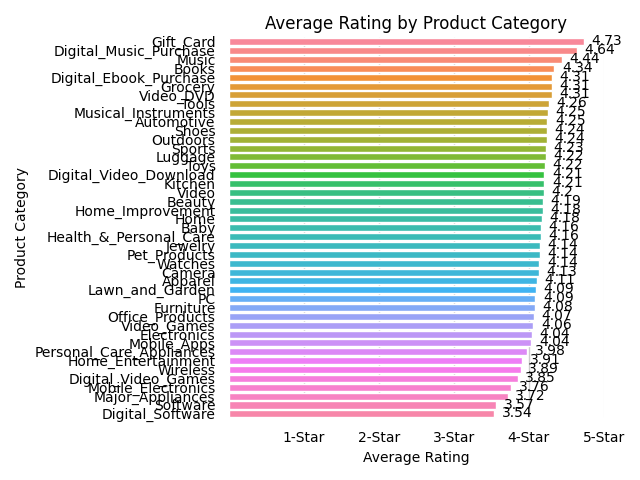

In [7]:
# 清空当前的图形
plt.clf()

# 创建条形图，y轴是产品类别，x轴是平均星级评分
barplot = sns.barplot(y="product_category", x="avg_star_rating", data=df.toPandas(), saturation=1)

# 如果产品类别数量少于10，设置图形大小
if num_categories < 10:
    sns.set(rc={"figure.figsize": (10.0, 5.0)})

# 设置图形的标题和x轴的标签
plt.title("Average Rating by Product Category")
plt.xticks([1, 2, 3, 4, 5], ["1-Star", "2-Star", "3-Star", "4-Star", "5-Star"])

# 调用自定义函数 show_values_barplot 在每个条形上显示具体数值，0.1 是数值标签的位置参数
show_values_barplot(barplot, 0.1)

# 设置x轴和y轴的标签
plt.xlabel("Average Rating")
plt.ylabel("Product Category")

# 如果需要，可以导出图形
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# 显示图形
plt.show()

# 在 Jupyter notebook 中显示 Matplotlib 生成的图形
%matplot plt

# 2. 哪些产品类别的评论最多？
## _This query takes a minute or two.  Please be patient._

请注意，在此单元格中，使用 PySpark 语法来处理 Glue 表中的数据，而上一节则使用 Spark SQL。

In [8]:
"""
这段代码的主要目的是从指定的数据库和表中查询各个产品类别的评论数量，并按照这个数量进行降序排序，显示前50条结果。
"""

# 导入 PySpark SQL 函数库
from pyspark.sql import functions as f

# 使用 Spark SQL 从指定数据库和表中取得所有数据
df_raw = spark.sql("SELECT * FROM {}.{}".format(database_name, table_name))

# 对原始数据进行处理
df = (
    df_raw
    # 选择 'product_category' 和 'star_rating' 列
    .select("product_category", "star_rating")
    # 按 'product_category' 列进行分组
    .groupBy("product_category")
    # 对每个产品类别的 'star_rating' 列进行计数，并将计数结果命名为 'count_star_rating'
    .agg(f.count("star_rating").alias("count_star_rating"))
    # 按 'count_star_rating' 列的值进行降序排序
    .orderBy("count_star_rating", ascending=False)
)

# 显示查询结果的前 50 行，并且关闭数据截断，即完整显示每一列的数据
df.show(50, truncate=False)

+------------------------+-----------------+
|product_category        |count_star_rating|
+------------------------+-----------------+
|Books                   |20726160         |
|Digital_Ebook_Purchase  |19180765         |
|Wireless                |9038249          |
|Video_DVD               |7135819          |
|PC                      |7004337          |
|Mobile_Apps             |6807166          |
|Home                    |6228567          |
|Music                   |6177781          |
|Apparel                 |5906460          |
|Health_&_Personal_Care  |5332883          |
|Digital_Video_Download  |5173743          |
|Beauty                  |5115721          |
|Toys                    |4981601          |
|Kitchen                 |4882831          |
|Sports                  |4860054          |
|Shoes                   |4379475          |
|Automotive              |3516476          |
|Electronics             |3120938          |
|Office_Products         |2646491          |
|Pet_Produ

In [9]:
# 将 Spark Dataframe 转为 Pandas Dataframe，然后取出 'count_star_rating' 这一列（即各个产品类别的评论数量），并将其存储在 count_ratings 变量中
count_ratings = df.toPandas()["count_star_rating"]

# 将 Spark Dataframe 转为 Pandas Dataframe，然后取出 'count_star_rating' 这一列的最大值（即评论数量最多的产品类别的评论数量），并将其存储在 max_ratings 变量中
max_ratings = df.toPandas()["count_star_rating"].max()

## 可视化

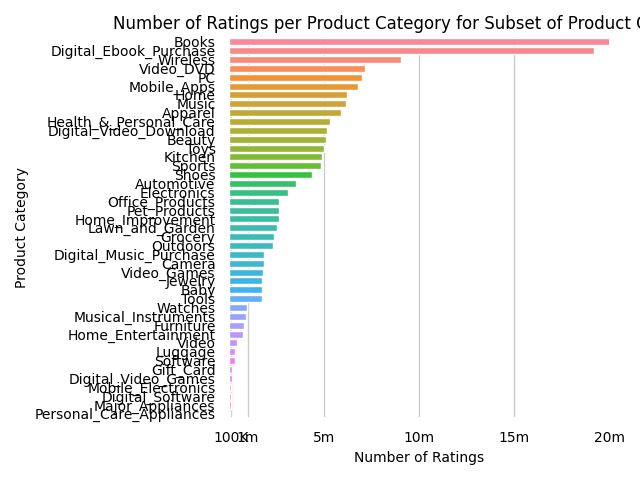

In [10]:
# 清空当前的图形
plt.clf()

# 创建条形图，y轴是产品类别，x轴是评论数量
barplot = sns.barplot(y="product_category", x="count_star_rating", data=df.toPandas(), saturation=1)

# 如果产品类别数量少于10，设置图形大小
if num_categories < 10:
    sns.set(rc={"figure.figsize": (10.0, 5.0)})

# 设置图形的标题
plt.title("Number of Ratings per Product Category for Subset of Product Categories")

# 根据最大评论数量设置x轴的刻度和范围
if max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ["100K", "1m", "5m", "10m", "15m", "20m"])
    plt.xlim(0, 20000000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ["50K", "100K", "150K", "200K"])
    plt.xlim(0, 200000)

# 设置x轴和y轴的标签
plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

# 如果需要，可以导出图形
plt.tight_layout()
# plt.savefig('ratings_per_category.png', dpi=300)

# 显示图形
plt.show()

# 在 Jupyter notebook 中显示 Matplotlib 生成的图形
%matplot plt

# 3. 根据第一次评论的日期，判断每个商品类别何时出现在亚马逊目录中？
## _This query takes a minute or two.  Please be patient._

In [11]:
# 使用 Spark SQL 查询每个产品类别的最早评论年份（自1995年起）
df = spark.sql("""
    SELECT product_category, MIN(year) AS first_review_year
    FROM {}.{}
    WHERE year >= 1995
    GROUP BY product_category
    ORDER BY first_review_year 
""".format(database_name, table_name)
)

# 显示查询结果的前 50 行，并且关闭数据截断，即完整显示每一列的数据
df.show(50, truncate=False)

+------------------------+-----------------+
|product_category        |first_review_year|
+------------------------+-----------------+
|Video                   |1995             |
|Music                   |1995             |
|Books                   |1995             |
|Video_DVD               |1996             |
|Toys                    |1997             |
|Sports                  |1997             |
|Video_Games             |1997             |
|Home_Entertainment      |1998             |
|Camera                  |1998             |
|Software                |1998             |
|Pet_Products            |1998             |
|Wireless                |1998             |
|Office_Products         |1998             |
|Home                    |1998             |
|Electronics             |1999             |
|Baby                    |1999             |
|Tools                   |1999             |
|Musical_Instruments     |1999             |
|PC                      |1999             |
|Automotiv

In [12]:
def get_x_y(df):
    """
    从 DataFrame 中获取 X 和 Y 坐标；返回包含两个元素的元组
    """
    # 对 'first_review_year' 列进行计数，并按照索引（即年份）进行排序
    series = df["first_review_year"].value_counts().sort_index()
    # new_series = series.reindex(range(1,21)).fillna(0).astype(int)
    # 返回年份（作为 X 坐标）和对应的计数（作为 Y 坐标）
    return series.index, series.values

In [13]:
X, Y = get_x_y(df.toPandas())
print(X)
print(Y)

Int64Index([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2004, 2006, 2008,
            2010],
           dtype='int64')
[ 3  1  3  7 13  8  3  1  1  1  1  1]


## 可视化

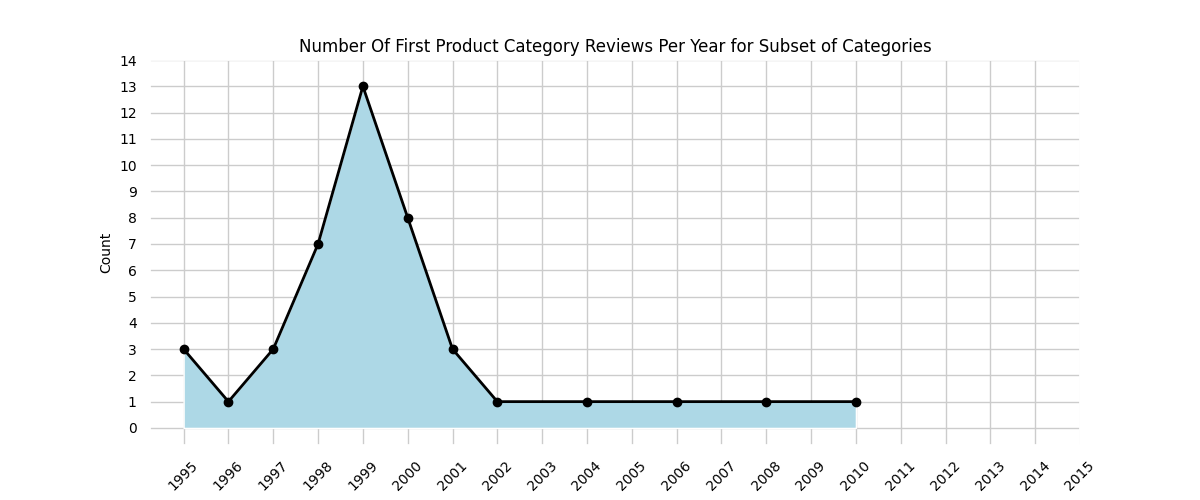

In [14]:
"""
这段代码的主要目的是创建一个线图，展示每年首次出现的产品类别的数量。
图形的标题、x轴和y轴的标签都已经明确的设置。
此外，线图下方的区域被填充为浅蓝色，x轴和y轴的刻度也进行了调整，x轴的刻度标签被旋转了45度，使其更易于阅读。
最后，图形可以被保存为本地的PNG文件，也可以直接在Jupyter notebook中展示出来。
"""

# 清空当前的图形
plt.clf()

# 设置图形大小
fig = plt.figure(figsize=(12, 5))
# 获取当前的坐标轴
ax = plt.gca()

# 设置图形的标题，x轴和y轴的标签
ax.set_title("Number Of First Product Category Reviews Per Year for Subset of Categories")
ax.set_xlabel("Year")
ax.set_ylabel("Count")

# 绘制线图，使用黑色的线，线宽为2，标记点的形状为圆形
ax.plot(X, Y, color="black", linewidth=2, marker="o")
# 填充线图下方的区域，使用浅蓝色
ax.fill_between(X, [0] * len(X), Y, facecolor="lightblue")

# 设置坐标轴的刻度为整数
ax.locator_params(integer=True)

# 设置x轴和y轴的刻度
ax.set_xticks(range(1995, 2016, 1))
ax.set_yticks(range(0, max(Y) + 2, 1))

# 旋转x轴的刻度标签45度
plt.xticks(rotation=45)

# 如果需要，可以导出图形
# fig.savefig('first_reviews_per_year.png', dpi=300)

# 显示图形
plt.show()

# 在 Jupyter notebook 中显示 Matplotlib 生成的图形
%matplot plt

# 4. 每个产品类别的评分明细（1-5）是多少？
## _This query takes a minute or two.  Please be patient._


In [15]:
"""
这段代码的主要目的是查询每个产品类别的每个星级评分的评论数量，并按照产品类别的升序、星级评分的降序以及评论数量的升序进行排序，显示前50条结果。
"""

# 使用 Spark SQL 查询每个产品类别的每个星级评分的评论数量
df = spark.sql("""
    SELECT product_category, star_rating, COUNT(*) AS count_reviews
    FROM {}.{}
    GROUP BY  product_category, star_rating
    ORDER BY  product_category ASC, star_rating DESC, count_reviews
""".format(database_name, table_name)
)

# 显示查询结果的前 50 行，并且关闭数据截断，即完整显示每一列的数据
df.show(50, truncate=False)

+----------------------+-----------+-------------+
|product_category      |star_rating|count_reviews|
+----------------------+-----------+-------------+
|Apparel               |5          |3320651      |
|Apparel               |4          |1147254      |
|Apparel               |3          |623483       |
|Apparel               |2          |369608       |
|Apparel               |1          |445464       |
|Automotive            |5          |2301688      |
|Automotive            |4          |526898       |
|Automotive            |3          |240023       |
|Automotive            |2          |147843       |
|Automotive            |1          |300024       |
|Baby                  |5          |1078545      |
|Baby                  |4          |289129       |
|Baby                  |3          |150753       |
|Baby                  |2          |101427       |
|Baby                  |1          |145039       |
|Beauty                |5          |3254946      |
|Beauty                |4      

## 准备显示每个产品类别的星级评分比例百分比水平条形图

In [16]:
"""
这段代码的主要目的是分析每个产品类别以及每个星级评分下的评论数量。
首先，将 Spark DataFrame 转换为 Pandas DataFrame，然后按产品类别以及星级评分进行分组。
接着，计算每个星级评分下的评论数量之和，以及所有星级评分的评论数量之和。
最后，我们打印出所有星级评分的评论数量之和。
"""

# 将 Spark DataFrame 转换为 Pandas DataFrame，然后按产品类别以及星级评分进行分组
grouped_category = df.toPandas().groupby("product_category")
grouped_star = df.toPandas().groupby("star_rating")

# 计算每个星级评分下的评论数量之和
df_sum = df.toPandas().groupby(["star_rating"]).sum()

# 计算所有星级评分的评论数量之和
total = df_sum["count_reviews"].sum()
# 打印结果
print(total)

160796570


In [ ]:
# Create dictionary of product categories and array of star rating distribution per category
distribution = {}
count_reviews_per_star = []
i = 0

for category, ratings in grouped_category:
    count_reviews_per_star = []
    for star in ratings["star_rating"]:
        count_reviews_per_star.append(ratings.at[i, "count_reviews"])
        i = i + 1
    distribution[category] = count_reviews_per_star

# Check if distribution has been created succesfully
print(distribution)

In [ ]:
# Sort distribution by average rating per category
sorted_distribution = {}

average_star_ratings.iloc[:, 0]
for index, value in average_star_ratings.iloc[:, 0].items():
    sorted_distribution[value] = distribution[value]

In [ ]:
df_sorted_distribution_pct = pd.DataFrame(sorted_distribution).transpose().apply(
    lambda num_ratings: num_ratings/sum(num_ratings)*100, axis=1
)
df_sorted_distribution_pct.columns=['5', '4', '3', '2', '1']
df_sorted_distribution_pct

## Visualization

In [ ]:
plt.clf()

categories = df_sorted_distribution_pct.index

# Plot bars
if len(categories) > 10:
    plt.figure(figsize=(10,10))
else: 
    plt.figure(figsize=(10,5))

df_sorted_distribution_pct.plot(kind="barh", 
                                stacked=True, 
                                edgecolor='white',
                                width=1.0,
                                color=['green', 
                                       'orange', 
                                       'blue', 
                                       'purple', 
                                       'red'])

plt.title("Distribution of Reviews Per Rating Per Category", 
          fontsize='16')

plt.legend(bbox_to_anchor=(1.04,1), 
           loc="upper left",
           labels=['5-Star Ratings', 
                   '4-Star Ratings', 
                   '3-Star Ratings', 
                   '2-Star Ratings', 
                   '1-Star Ratings'])

plt.xlabel("% Breakdown of Star Ratings", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

%matplot plt

# 5. How Many Reviews per Star Rating? (5, 4, 3, 2, 1)
## _This query takes a minute or two.  Please be patient._

In [ ]:
# SQL statement
df = spark.sql("""
    SELECT star_rating, COUNT(*) AS count_reviews
    FROM {}.{}
    GROUP BY star_rating
    ORDER BY star_rating DESC, count_reviews 
""".format(database_name, table_name)
)

df.show()

In [ ]:
plt.clf()

chart = df.toPandas().plot.bar(
    x="star_rating", y="count_reviews", rot="0", figsize=(10, 5), title="Review Count by Star Ratings", legend=False
)

plt.xlabel("Star Rating")
plt.ylabel("Review Count")

plt.show()

%matplot plt

# 6. How Did Star Ratings Change Over Time?
Is there a drop-off point for certain product categories throughout the year?

## Average Star Rating Across All Product Categories
## _This query takes a minute or two.  Please be patient._

In [ ]:
# SQL statement
df = spark.sql("""
    SELECT year, ROUND(AVG(star_rating),4) AS avg_rating
    FROM {}.{}
    WHERE year >= 1995
    GROUP BY year
    ORDER BY year
""".format(database_name, table_name)
)

df.show(50, truncate=False)

In [ ]:
df.toPandas()["year"] = pd.to_datetime(df.toPandas()["year"], format="%Y").dt.year

## Visualization

In [ ]:
plt.clf()

fig = plt.gcf()
fig.set_size_inches(12, 5)

fig.suptitle("Average Star Rating Over Time (Across Subset of Product Categories)")

ax = plt.gca()
# ax = plt.gca().set_xticks(df['year'])
ax.locator_params(integer=True)
ax.set_xticks(df.toPandas()["year"].unique())

df.toPandas().plot(kind="line", x="year", y="avg_rating", color="red", ax=ax)

# plt.xticks(range(1995, 2016, 1))
# plt.yticks(range(0,6,1))
plt.xlabel("Years")
plt.ylabel("Average Star Rating")
plt.xticks(rotation=45)

# fig.savefig('average-rating.png', dpi=300)
plt.show()

%matplot plt

## Average Star Rating Per Product Categories Across Time
## _This query takes a minute or two.  Please be patient._

In [ ]:
# SQL statement
df = spark.sql("""
    SELECT product_category, year, ROUND(AVG(star_rating), 4) AS avg_rating_category
    FROM {}.{}
    WHERE year >= 1995
    GROUP BY product_category, year
    ORDER BY year 
""".format(database_name, table_name)
)

df.show(50, truncate=False)

## Visualization

In [ ]:
def plot_categories(df):
    df_categories = df["product_category"].unique()
    for category in df_categories:
        # print(category)
        df_plot = df.loc[df["product_category"] == category]
        df_plot.plot(
            kind="line",
            x="year",
            y="avg_rating_category",
            c=np.random.rand(
                3,
            ),
            ax=ax,
            label=category,
        )

In [ ]:
plt.clf()

fig = plt.gcf()
fig.set_size_inches(12, 5)

fig.suptitle("Average Star Rating Over Time Across Subset Of Categories")

ax = plt.gca()

ax.locator_params(integer=True)
ax.set_xticks(df.toPandas()["year"].unique())

plot_categories(df.toPandas())

plt.xlabel("Year")
plt.ylabel("Average Star Rating")
plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)

# fig.savefig('average_rating_category_all_data.png', dpi=300)
plt.show()

%matplot plt

# 7. Which Star Ratings (1-5) are Most Helpful?
## _This query takes a minute or two.  Please be patient._

In [ ]:
# SQL statement
df = spark.sql("""
    SELECT star_rating, AVG(helpful_votes) AS avg_helpful_votes
    FROM {}.{}
    GROUP BY  star_rating
    ORDER BY  star_rating ASC
""".format(database_name, table_name)
)

df.show()

## Visualization

In [ ]:
plt.clf()

chart = df.toPandas().plot.bar(
    x="star_rating", y="avg_helpful_votes", rot="0", figsize=(10, 5), title="Helpfulness Of Star Ratings", legend=False
)

plt.xlabel("Star Rating")
plt.ylabel("Average Helpful Votes")

plt.show()

%matplot plt

# 8. Which Products have Most Helpful Reviews?  How Long are the Most Helpful Reviews?
## _This query takes a minute or two.  Please be patient._

In [ ]:
# SQL statement
df = spark.sql("""
    SELECT product_title, helpful_votes, star_rating,
           LENGTH(review_body) AS review_body_length,
           SUBSTR(review_body, 1, 100) AS review_body_substr
    FROM {}.{}
    ORDER BY helpful_votes DESC LIMIT 10 
""".format(database_name, table_name)
)

df.show(50, truncate=False)

# 9. What is the Ratio of Positive (5, 4) to Negative (3, 2 ,1) Reviews?
## _This query takes a minute or two.  Please be patient._

In [ ]:
# SQL statement
df = spark.sql("""
    SELECT (CAST(positive_review_count AS DOUBLE) / CAST(negative_review_count AS DOUBLE)) AS positive_to_negative_sentiment_ratio
    FROM (
      SELECT count(*) AS positive_review_count
      FROM {}.{}
      WHERE star_rating >= 4

    ), (
      SELECT count(*) AS negative_review_count
      FROM {}.{}
      WHERE star_rating < 4 
    )
""".format(database_name, table_name, database_name, table_name)
)

df.show()

# 10. Which Customers are Abusing the Review System by Repeatedly Reviewing the Same Product?  What Was Their Average Star Rating for Each Product?
## _This query takes a minute or two.  Please be patient._

In [ ]:
# SQL statement
df = spark.sql("""
    SELECT customer_id, product_category, product_title, 
    ROUND(AVG(star_rating),4) AS avg_star_rating, COUNT(*) AS review_count 
    FROM {}.{} 
    GROUP BY customer_id, product_category, product_title 
    HAVING COUNT(*) > 1 
    ORDER BY review_count DESC
    LIMIT 50
""".format(database_name, table_name)
)

df.show(50, truncate=False)

In [ ]:
%stop_session

# Conclusions

Through this notebook, we have seen how you can use AWS Glue interactive sessions in SageMaker Studio to process large datasets at scale for ETL and EDA tasks. Benefits of this development paradigm include...

1. natively distributed processing which can scale with your datasets 
2. no need to manage cluster infrastructure
3. integration with SageMaker studio for a one stop shop for the ML lifecycle

# Release Resources

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>